<a href="https://colab.research.google.com/github/Liljekonvalj/bitbot-xl-test/blob/master/Kopia_av_Distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A neural network to calculate distance between gps coordinates.


Epoch 1/1000, Validation Loss: 118615.9341
Epoch 2/1000, Validation Loss: 115993.8927
Epoch 3/1000, Validation Loss: 115981.2583
Epoch 4/1000, Validation Loss: 115907.0282
Epoch 5/1000, Validation Loss: 115822.9161
Epoch 6/1000, Validation Loss: 115801.3103
Epoch 7/1000, Validation Loss: 115762.5400
Epoch 8/1000, Validation Loss: 115618.1022
Epoch 9/1000, Validation Loss: 115528.4778
Epoch 10/1000, Validation Loss: 115617.8980
Epoch 11/1000, Validation Loss: 115389.4770
Epoch 12/1000, Validation Loss: 115141.2360
Epoch 13/1000, Validation Loss: 114953.3771
Epoch 14/1000, Validation Loss: 114933.2969
Epoch 15/1000, Validation Loss: 114540.5427
Epoch 16/1000, Validation Loss: 114574.6108
Epoch 17/1000, Validation Loss: 114099.6911
Epoch 18/1000, Validation Loss: 113766.1652
Epoch 19/1000, Validation Loss: 113427.1246
Epoch 20/1000, Validation Loss: 113067.7277
Epoch 21/1000, Validation Loss: 112643.0623
Epoch 22/1000, Validation Loss: 112168.5695
Epoch 23/1000, Validation Loss: 111412.61

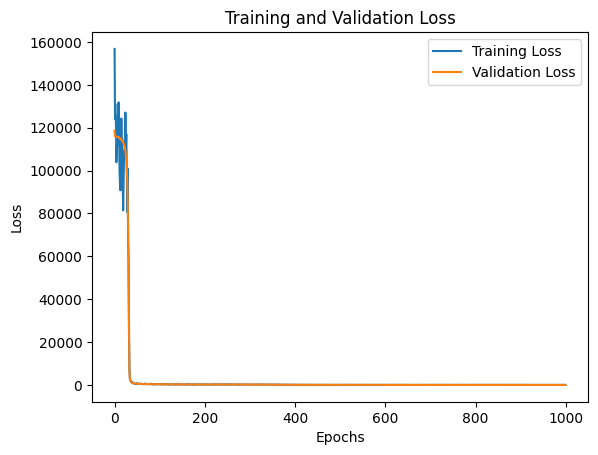

Test Loss: 12.7095


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the data
df_dataset = pd.read_csv('/content/sweden_gps_distances (2).csv')  # Adjust path if necessary

# Assuming your DataFrame is named 'df_dataset'
X = df_dataset[['latitude1', 'longitude1', 'latitude2', 'longitude2']].values
y = df_dataset['distance'].values

# Scale the input features (X)
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% validation, 15% test

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 128) #Increased neurons in first layer
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, 1) #New layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x= torch.relu(self.fc3(x))
        x = self.fc4(x) #Output from the new layer
        return x

# Create the model, optimizer, and loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001) #Change learning rate here
criterion = nn.MSELoss()

# Train the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()
    val_loss /= len(val_loader)
    train_losses.append(loss.item())  # Assuming 'loss' is your training loss
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}')

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
test_loss = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += criterion(output, target).item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

# Benchmarking
Download this test file https://drive.google.com/file/d/14w8G4bwQEyMK5OacejnlwbxFexiufgP6/view?usp=drive_link

And run the following code to test how well your network performs. Then note your best results.

In [4]:
import pandas as pd
import numpy as np

# Load the test dataset
df_test = pd.read_csv('/content/sweden_gps_test_distances.csv')

# Prepare the input features for prediction
X_test_data = df_test[['latitude1', 'longitude1', 'latitude2', 'longitude2']].values
X_test_tensor_data = torch.tensor(X_test_data, dtype=torch.float32)

# Make predictions
with torch.no_grad():
    predicted_distances = model(X_test_tensor_data).numpy().flatten()

# Calculate errors
errors = np.abs(predicted_distances - df_test['distance'].values)

# Calculate average error and standard deviation
avg_error = np.mean(errors)
std_dev_error = np.std(errors)

# Find the maximum and minimum errors
max_error_index = np.argmax(errors)
max_error = errors[max_error_index]
min_error_index = np.argmin(errors)
min_error = errors[min_error_index]

# Print results
print(f'Average Error (km): {avg_error}')
print(f'Standard Deviation of Error (km): {std_dev_error}')
print(f'Row with Maximum Error: {max_error_index}, Error (km): {max_error}')
print(f'Row with Minimum Error: {min_error_index}, Error (km): {min_error}')


Average Error (km): 2.617031410304433
Standard Deviation of Error (km): 2.1410900729595337
Row with Maximum Error: 435, Error (km): 16.21428666483189
Row with Minimum Error: 618, Error (km): 0.006729235939900491


# Resultat med 1000 rader i skapade träningsdata, batch-size=32, lr=0.001, epochs=200:

Medelfel=277.66 km

Standardavvikelse för felet: 227.29 km

Rad med maximalt fel: 150, fel=1128.83 km

Rad med minimalt fel: 862, fel=0.49 km

# Ny körning kommer att göras med 10 000 rader i skapade träningsdata, batch-size=64, lr=0.001, epochs=500:

Träningsdata tycks ha fått mindre fel, men nu testar vi ovanstående program med dessa nya träningsdata.





Fortsättning: Det blev lite bättre:

Medelfel = 14.18 km

Standardavvikelse för felet = 14.18 km

Rad med maximalt fel: 398, Fel= 108.48 km

Rad med minimalt fel: 459, Fel = 0.04 km

# Ny körning med 100 000 rader skapade träningsdata, batch-size=128, lr=0.0001, epochs=1000:

Average Error (km): 13.492363344339534
Standard Deviation of Error (km): 11.65328158314889
Row with Maximum Error: 46, Error (km): 76.31343812400002
Row with Minimum Error: 420, Error (km): 0.016107736897311042

Här reducerades felen ännu mer.
Vi kan testa att öka antal lager också:

Ny körning med 4 lager, 100 1000 rader träningsdata, batch-size= 128 , lr= 0.0001  , epochs=1000 :
Värdena har blivit ännu lite bättre.

Average Error (km): 2.617031410304433

Standard Deviation of Error (km): 2.1410900729595337

Row with Maximum Error: 435, Error (km): 16.21428666483189

Row with Minimum Error: 618, Error (km): 0.006729235939900491